In [1]:
import os
import pycrs
import geopandas as gpd
import matplotlib.pyplot as plt 
import rasterio as rio 
from rasterio.mask import mask 
from rasterio.plot import show 

from coasty import postprocess

ModuleNotFoundError: No module named 'pycrs'

In [69]:
data_dir = "/Users/Ronjamac/Documents/02_Studium/Masterarbeit/Code/VN_coastline_dynamics/test_data"
raster_file = "1_1988_L5_P1_13aq.tif"
raster_file_masked = "1_1988_L5_P1_13aq_masked.tif"
box_file = "test_box.geojson"

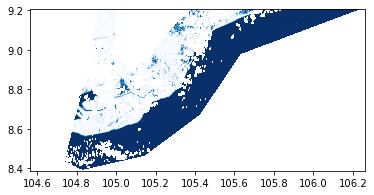

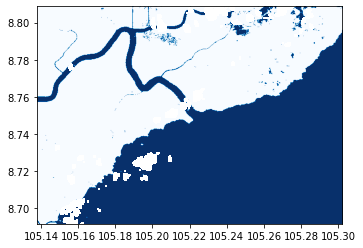

In [26]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

raster = rio.open(os.path.join(data_dir,raster_file))
box = gpd.read_file(os.path.join(data_dir,box_file))
show(raster,cmap="Blues")

coords = getFeatures(box)
out_img, out_transform = mask(dataset=raster, shapes=coords, crop=True, filled=False)
out_meta = raster.meta.copy()
epsg_code = int(raster.crs.data['init'][5:])
out_meta.update({"driver":"GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})
with rio.open(os.path.join(data_dir,raster_file_masked),"w", **out_meta) as dest:
    dest.write(out_img)

raster_masked = rio.open(os.path.join(data_dir,raster_file_masked))
show(raster_masked,cmap="Blues")

In [64]:
shoreline = postprocess.subpixel_contours(raster_masked, raster_masked.crs, 30)
shoreline.to_file(os.path.join(data_dir,raster_file_masked+"_shoreline"),driver="GeoJSON")

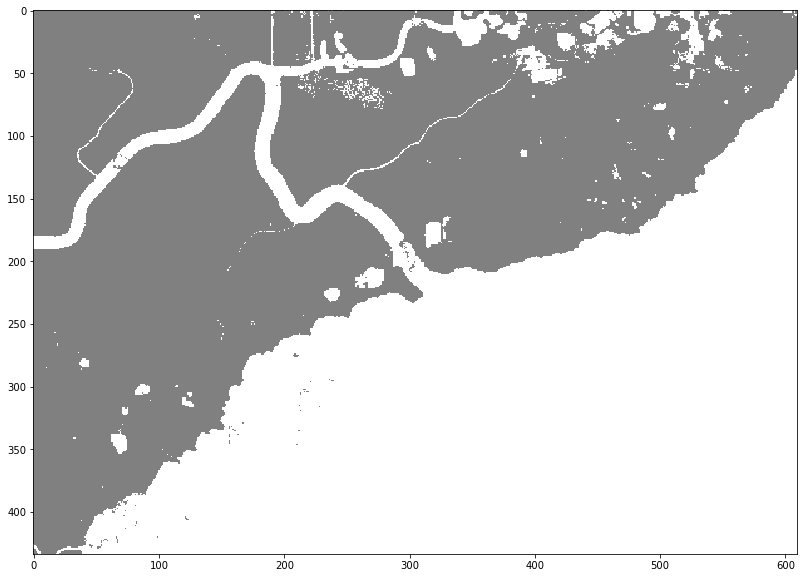

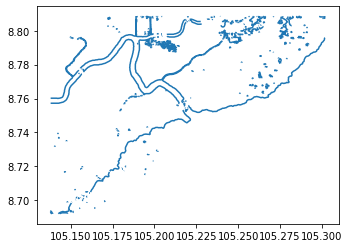

In [63]:
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(raster_masked.read(1),cmap='gray',alpha=0.5,interpolation='none')
shoreline.plot()

In [71]:
postprocess.subpixel_contours?

Signature:
postprocess.subpixel_contours(
    raster,
    crs,
    scale,
    threshold=0.5,
    sigma=3,
    plot=False,
)
Docstring:
Uses skimage.measure.find_contours to extract contours from a binary image. 
Smoothens contour line with scipy.interpolate to achieve a subpixel border
segmentation. 

Parameters
----------
raster: rasterio raster image 
threshold: threshold where to draw the contour line, default to 0.5
scale: pixel resolution of input raster    
plot: whether yes or not to plot the results 
File:      ~/Documents/02_Studium/Masterarbeit/Code/VN_coastline_dynamics/coasty/postprocess.py
Type:      function
